In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from scipy import interpolate
from scipy.optimize import least_squares
import array

%matplotlib inline

In [ ]:
spx = pd.read_csv('SPX_options.csv')
spy = pd.read_csv('SPY_options.csv')
rates = pd.read_csv('zero_rates_20201201.csv')

# steps = 2000 #declared in extract_early_ex_premium()
beta = 0.7

spx['strike_price'] = spx['strike_price']/1000
spy['strike_price'] = spy['strike_price']/100

# Calculating Mid Price (using it to calculate market implied volatility)
spx['midprice'] = (spx['best_bid'] + spx['best_offer']) / 2
spy['midprice'] = (spy['best_bid'] + spy['best_offer']) / 0.2

# Changing columns to datetime format
spx['exdate'] = pd.to_datetime(spx['exdate'],format='%Y%m%d')
spx['date'] = pd.to_datetime(spx['date'],format='%Y%m%d')
spx['maturityDays'] = (spx['exdate'] - spx['date']).astype('timedelta64[D]')
maturitiesDays_spx =  spx['maturityDays'].unique()

spy['exdate'] = pd.to_datetime(spy['exdate'],format='%Y%m%d')
spy['date'] = pd.to_datetime(spy['date'],format='%Y%m%d')
spy['maturityDays'] = (spy['exdate'] - spy['date']).astype('timedelta64[D]')
maturitiesDays_spy =  spy['maturityDays'].unique()

# Inteprolating rates
iRates = []
f=interpolate.interp1d(rates['days'].values,rates['rate'].values)

# Doing this once since maturitiesDays_spx == maturitiesDays_spy
for day in maturitiesDays_spx:
    tempRate=f(int(day))
    r = tempRate / 100
    iRates.append(r)


$ {\sigma} = log(u) * \frac{1}{\sqrt{\triangle t}} $ (u is unknown)

$ \triangle t = \frac{T}{n} $ 

We decided to fix  $ {\sigma} $ = 0.15 when we run the Binomial Tree model as it can be seen below that by varying sigma, the difference between American and European options are very small.

In [ ]:
# S = 10.0
# K = 10.0
# r = 0.05
# T = 1
# steps = 2000
# sigma = np.arange(0.15, 1.05, 0.15)

# for sig in sigma:
#     print(f"sigma = {round(sig, 2)}")
#     print('American Call price: %.4f' % american_call(S, K, r, sig, T, steps))
#     print('European Call price: %.4f' % european_call(S, K, r, sig, T, steps))
#     print('American Put price: %.4f' % american_put(S, K, r, sig, T, steps))
#     print('European Put price: %.4f' % european_put(S, K, r, sig, T, steps))
#     print("")

In [ ]:
# For American exercise type, we can no longer use the analytical formula provided by Black and Scholes. 
# However, the binomial tree model can handle American options, through the "backward induction" method.

def american_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    prices = array.array('d', (0 for i in range(0, steps+1)))

    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]
            call_values[i] = max(call_values[i], 1.0*(prices[i]-K))

    return call_values[0]

def american_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
            put_values[i] = max(put_values[i], (K-prices[i]))
    return put_values[0]

def european_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    # price of underlying
    prices = array.array('d', (0 for i in range(0, steps+1)))

    # fill in the endnodes
    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]

    return call_values[0]

def european_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
    return put_values[0]

In [ ]:
#Black scholes model
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*(T)) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*(T))*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*(T)) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*(T))*norm.cdf(-d2) - S*norm.cdf(-d1)

#DDM Model
def DDMCall(F, K, r, sigma, T, beta):
    d1_DDM = (np.log((F/beta)/(K+((1-beta)/beta)*F))+((beta*sigma)**2/2)*T) / (beta*sigma*np.sqrt(T))
    d2_DDM = d1_DDM - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*((F/beta)*norm.cdf(d1_DDM) - (K+((1-beta)/beta)*F)*norm.cdf(d2_DDM))

def DDMPut(F, K, r, sigma, T, beta):
    d1_DDM = (np.log((F/beta)/(K+((1-beta)/beta)*F))+((beta*sigma)**2/2)*T) / (beta*sigma*np.sqrt(T))
    d2_DDM = d1_DDM - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*((K+((1-beta)/beta)*F)*norm.cdf(-d2_DDM) - (F/beta)*norm.cdf(-d1_DDM))

#SABR function
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

# Calibration of SABR and DDM model parameters
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def ddcalibration(x, strikes, prices, F, T, r, payoff):
    err = 0.0
    for i, price in enumerate(prices):
        if (payoff[i].lower() == 'c'):
            err += (price - DDMCall(F, strikes[i], r, x[0], T, x[1]))**2                          
        elif (payoff[i].lower() == 'p'):
             err += (price - DDMPut(F, strikes[i], r, x[0], T, x[1]))**2
        else:
            raise NameError('Payoff type not recognized')
    return err

In [ ]:
def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def extract_early_ex_premium():
    # Let sigma = 0.15 and steps = 2000 
    SPYp = 366.02 *10
    sigma = 0.15
    steps = 20

    early_ex = []

    for day in maturitiesDays_spy:
        tempIndex = np.where(maturitiesDays_spy == day)[0][0]
        r = iRates[tempIndex]
        T = day /365
        F = SPYp * np.exp(r*T)
        tempDf = spy[spy['maturityDays'] == day]
        tempDf['r']  = r
        tempDf['T']  = T
        tempDf['F']  = F
        tempDf['S']  = SPYp

        for i in range(len(tempDf)):

            if (tempDf['cp_flag'].iloc[i] == 'C'):
                # sigma = impliedVolatility_US(SPYp,  tempDf.strike_price.iloc[i], tempDf.r.iloc[i], tempDf.midprice.iloc[i], T, 'call', steps)
                us_call = american_call(SPYp, tempDf.strike_price.iloc[i], tempDf.r.iloc[i], sigma, T, steps)
                # eu_call = european_call(SPYp, tempDf.strike_price.iloc[i], tempDf.r.iloc[i], sigma, T, steps)
                eu_call = BlackScholesCall(SPYp, tempDf.strike_price.iloc[i], tempDf.r.iloc[i], sigma, T)
                early_ex.append(us_call - eu_call)

            elif (tempDf['cp_flag'].iloc[i] == 'P'):
                # sigma = impliedVolatility_US(SPYp,  tempDf.strike_price.iloc[i], tempDf.r.iloc[i], tempDf.midprice.iloc[i], T, 'put', steps)
                us_put = american_put(SPYp, tempDf.strike_price.iloc[i], tempDf.r.iloc[i], sigma, T, steps)
                # eu_put = european_put(SPYp, tempDf.strike_price.iloc[i], tempDf.r.iloc[i], sigma, T, steps)
                eu_put = BlackScholesPut(SPYp, tempDf.strike_price.iloc[i], tempDf.r.iloc[i], sigma, T)
                early_ex.append(us_put - eu_put)

    return early_ex

In [ ]:
# Calibrating for SPX options (Calculating Market Implied Volatility across the 3 maturities)
def spx_with_impVol():
    # SPX price today
    SPXp = 3662.45
    SPXresult = pd.DataFrame()

    for day in maturitiesDays_spx:
        tempIndex = np.where(maturitiesDays_spx == day)[0][0]
        r = iRates[tempIndex]
        T = day /365
        F = SPXp * np.exp(r*T)
        tempDf = spx[(spx['maturityDays'] == day)]
        tempDf['r']  = r
        tempDf['T']  = T
        tempDf['F']  = F
        tempDf['S']  = SPXp
        
        #Filtering options prices (if K < F: use put, if K > F: use call)
        tempDfCall = tempDf.drop(tempDf.index[(tempDf['strike_price'] < F) | (tempDf['cp_flag'] == 'P')])
        tempDfPut = tempDf.drop(tempDf.index[(tempDf['strike_price'] > F) | (tempDf['cp_flag'] == 'C')]) 
        
        #Calculating mkt implied vol for SPX Call
        otmc_p = tempDfCall['midprice']
        otmc_k = tempDfCall['strike_price']
        tempCallVol = []
        for i in range(len(otmc_p)):
            impliedvol = impliedVolatility(SPXp, otmc_k.iloc[i], r, otmc_p.iloc[i], T, 'call')
            tempCallVol.append(impliedvol)

        tempDfCall['impliedVol'] = tempCallVol

        #calculating mkt implied vol for SPX Put
        otmp_p = tempDfPut['midprice']
        otmp_k = tempDfPut['strike_price']
        tempPutVol = []
        for i in range(len(otmp_p)):
            impliedvol = impliedVolatility(SPXp, otmp_k.iloc[ i], r, otmp_p.iloc[i], T, 'put')
            tempPutVol.append(impliedvol)

        tempDfPut['impliedVol'] = tempPutVol

        #Consolidating data across maturities
        SPXresult = SPXresult.append(tempDfPut, ignore_index = True)
        SPXresult = SPXresult.append(tempDfCall, ignore_index = True)

    return SPXresult

# Calibrating for SPY options (Calculating Market Implied Volatility across the 3 maturities)
def spy_with_impVol():
    SPYp = 366.02*10
    SPYresult = pd.DataFrame()

    for day in maturitiesDays_spy:
        tempIndex = np.where(maturitiesDays_spy == day)[0][0]
        r = iRates[tempIndex]
        T = day /365
        F = SPYp * np.exp(r*T)
        tempDf = spy[spy['maturityDays'] == day]
        tempDf['r']  = r
        tempDf['T']  = T
        tempDf['F']  = F
        tempDf['S']  = SPYp

        tempVol = []

        tempDfCall = tempDf.drop(tempDf.index[(tempDf['strike_price'] < F) | (tempDf['cp_flag'] == 'P')])
        tempDfPut = tempDf.drop(tempDf.index[(tempDf['strike_price'] > F) | (tempDf['cp_flag'] == 'C')]) 

        #Calculating mkt implied vol for SPY Call
        otmc_p = tempDfCall['midprice'] - tempDfCall["Early Exercise Premium"]
        otmc_k = tempDfCall['strike_price']

        tempCallVol = []
        for i in range(len(otmc_p)):
            impliedvol = impliedVolatility(SPYp, otmc_k.iloc[i], r, otmc_p.iloc[i], T, 'call')
            tempCallVol.append(impliedvol)

        tempDfCall['impliedVol'] = tempCallVol

        #calculating mkt implied vol for SPY Put
        otmp_p = tempDfPut['midprice'] - tempDfPut["Early Exercise Premium"]
        otmp_k = tempDfPut['strike_price']

        tempPutVol = []
        for i in range(len(otmp_p)):
            impliedvol = impliedVolatility(SPYp, otmp_k.iloc[ i], r, otmp_p.iloc[i], T, 'put')
            tempPutVol.append(impliedvol)

        tempDfPut['impliedVol'] = tempPutVol

        #Consolidating data across maturities
        SPYresult= SPYresult.append(tempDfPut, ignore_index = True)
        SPYresult= SPYresult.append(tempDfCall, ignore_index = True)

    return SPYresult

In [ ]:
# Function to plot Implied Volatility graph 
def plotimpliedVol(df, maturity):
    F = df['F'].values[0]
    T = df['T'].values[0]
    r = df['r'].values[0]
    S = df['S'].values[0]
    
    initialGuessSABR = [0.02, 0.2, 0.1]
    initialGuessDD = [0.02, 0.1]

    SABRres = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike_price'].values,
                                                  df['impliedVol'].values,
                                                  F,
                                                  T),
                                                  initialGuessSABR)
    alpha = SABRres.x[0]
    rho = SABRres.x[1]
    nu = SABRres.x[2]

    print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % 
          (alpha, beta, rho, nu))
    DDres = least_squares(lambda x: ddcalibration(x,
                                                  df['strike_price'].values,
                                                  df['midprice'].values,
                                                  F,
                                                  T,
                                                  r,
                                                  df['cp_flag'].values),
                                                  initialGuessDD,
                                                  bounds = ([-np.inf,  0],[np.inf, 1]))
                            
    sigma = DDres.x[0]
    ddbeta = DDres.x[1]
    print('Calibrated Displaced Diffusion model parameters: sigma = %.3f, beta = %.3f' % (sigma, ddbeta))
    
    sabrvols = []
    for K in df['strike_price']:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))
    
    ddvols = []
    # ddPrice = []
    for i, strike in enumerate(df['strike_price'].values):
        if (df['cp_flag'].values[i].lower() == 'c'):
            tempPrice = DDMCall(F, strike, r, sigma, T, ddbeta) 
            ddvols.append(impliedVolatility(S, strike, r, tempPrice, T, 'call'))
        elif (df['cp_flag'].values[i].lower() == 'p'):
            tempPrice = DDMPut(F, strike, r, sigma, T, ddbeta)
            ddvols.append(impliedVolatility(S, strike, r, tempPrice, T, 'put'))
    
    plt.figure(tight_layout=True, figsize = (8,6))
    plt.plot(df['strike_price'], df['impliedVol'], 'gs', label='Market Vols')
    plt.plot(df['strike_price'], sabrvols, 'b--', label='SABR Vols')
    plt.plot(df['strike_price'], ddvols, 'r--', label='Displaced Diffusion Vols')
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.title("Graph of Implied Volatility against Strike Price for Maturity = {} days".format(maturity))
    plt.legend()
    plt.show()

In [ ]:
SPXresult = spx_with_impVol()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460
Calibrated Displaced Diffusion model parameters: sigma = 0.183, beta = 0.098


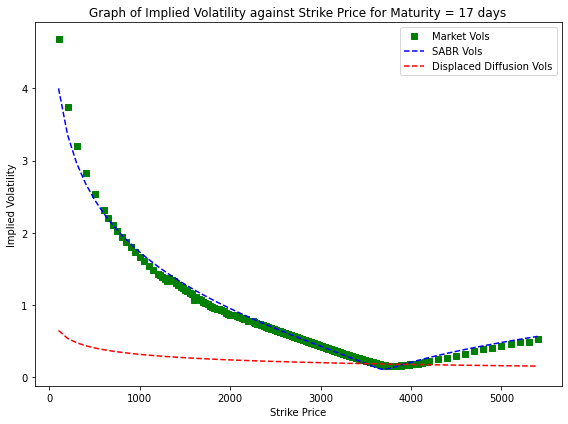

In [ ]:
# SPXresult for maturity of 17 days - 20201218
tempResult1 = SPXresult[SPXresult['maturityDays'] == 17.0]
plotimpliedVol(tempResult1, 17)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790
Calibrated Displaced Diffusion model parameters: sigma = 0.195, beta = 0.095


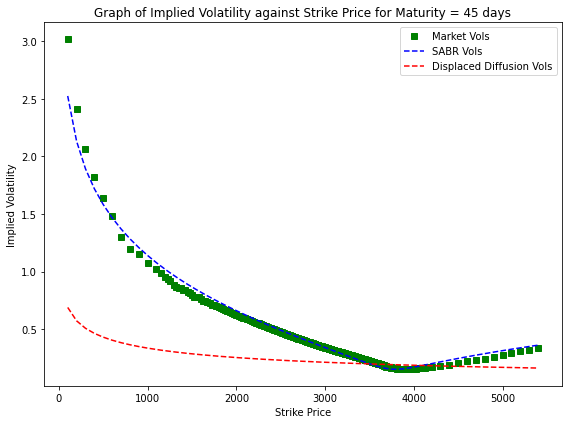

In [ ]:
# SPXresult for maturity of 45 days - 20210115
tempResult2 = SPXresult[SPXresult['maturityDays'] == 45.0]
plotimpliedVol(tempResult2, 45)

Calibrated SABR model parameters: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842
Calibrated Displaced Diffusion model parameters: sigma = 0.202, beta = 0.091


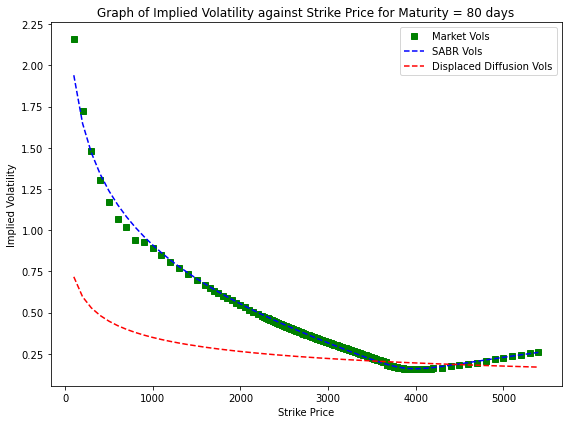

In [ ]:
# SPXresult for maturity of 80 days - 20210219
tempResult3 = SPXresult[SPXresult['maturityDays'] == 80.0]
plotimpliedVol(tempResult3, 80)

In [ ]:
spy['Early Exercise Premium'] = extract_early_ex_premium()
SPYresult = spy_with_impVol()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
Calibrated SABR model parameters: alpha = 1.327, beta = 0.7, rho = -0.410, nu = 5.251
Calibrated Displaced Diffusion model parameters: sigma = 0.194, beta = 0.097


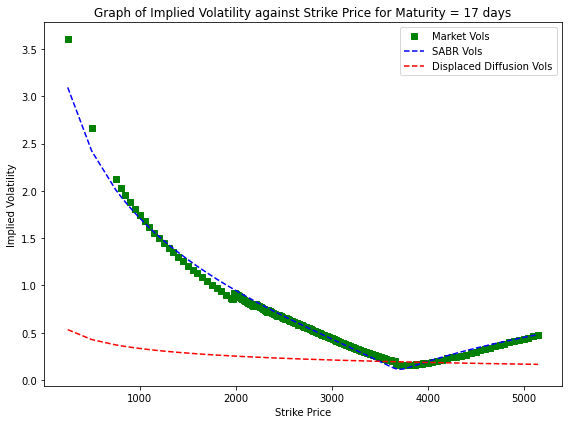

In [ ]:
# SPYresult for maturity of 17 days - 20201218
tempResult4 = SPYresult[SPYresult['maturityDays'] == 17.0]
plotimpliedVol(tempResult4, 17)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
Calibrated SABR model parameters: alpha = 1.812, beta = 0.7, rho = -0.487, nu = 2.729
Calibrated Displaced Diffusion model parameters: sigma = 0.195, beta = 0.094


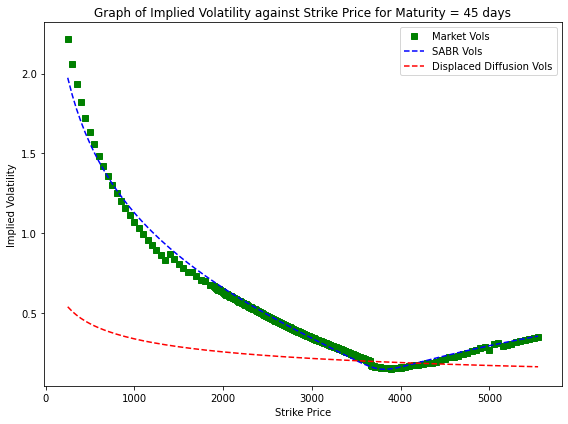

In [ ]:
# SPYresult for maturity of 45 days - 20210115
tempResult5 = SPYresult[SPYresult['maturityDays'] == 45.0]
plotimpliedVol(tempResult5, 45)

Calibrated SABR model parameters: alpha = 2.234, beta = 0.7, rho = -0.630, nu = 1.747
Calibrated Displaced Diffusion model parameters: sigma = 0.203, beta = 0.091


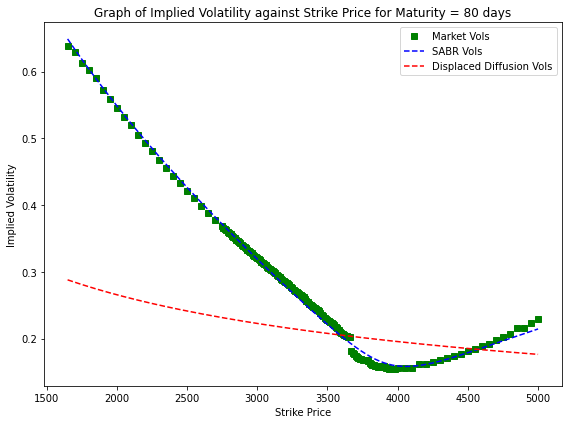

In [ ]:
# SPYresult for maturity of 80 days - 20210219
tempResult6 = SPYresult[SPYresult['maturityDays'] == 80.0]
plotimpliedVol(tempResult6, 80)

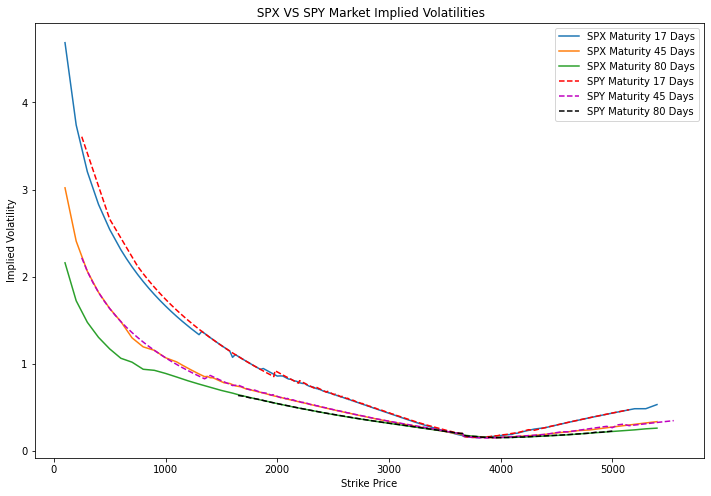

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
# SPXresult.groupby("maturityDays").plot(x='strike_price', y='impliedVol', ax=ax)
SPXresult[SPXresult.maturityDays == 17.0].plot(x='strike_price', y='impliedVol', ax=ax, label = "SPX Maturity 17 Days")
SPXresult[SPXresult.maturityDays == 45.0].plot(x='strike_price', y='impliedVol', ax=ax, label = "SPX Maturity 45 Days")
SPXresult[SPXresult.maturityDays == 80.0].plot(x='strike_price', y='impliedVol', ax=ax, label = "SPX Maturity 80 Days")

# SPYresult.groupby("maturityDays").plot(x='strike_price', y='impliedVol', ax=ax)
SPYresult[SPYresult.maturityDays == 17.0].plot(x='strike_price', y='impliedVol', style = 'r--', ax=ax, label = "SPY Maturity 17 Days")
SPYresult[SPYresult.maturityDays == 45.0].plot(x='strike_price', y='impliedVol', style = 'm--', ax=ax, label = "SPY Maturity 45 Days")
SPYresult[SPYresult.maturityDays == 80.0].plot(x='strike_price', y='impliedVol', style = 'k--', ax=ax, label = "SPY Maturity 80 Days")

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title(" SPX VS SPY Market Implied Volatilities")
plt.show()

Discuss how does change β in the displaced-diffusion model affect the shape of the implied volatility smile.

In [ ]:
def plotDDM(df, sigma, ddbeta):
    F = df['F'].values[0]
    T = df['T'].values[0]
    r = df['r'].values[0]
    S = df['S'].values[0]

    for j, beta in enumerate(ddbeta):

        ddvols = []

        for i, strike in enumerate(df['strike_price'].values):
            if (df['cp_flag'].values[i].lower() == 'c'):
                tempPrice = DDMCall(F, strike, r, sigma, T, beta) 
                ddvols.append(impliedVolatility(S, strike, r, tempPrice, T, 'call'))

            else:
                tempPrice = DDMPut(F, strike, r, sigma, T, beta)
                ddvols.append(impliedVolatility(S, strike, r, tempPrice, T, 'put'))

        globals()[f"beta_{j+1}"] = ddvols

    fig = plt.figure(tight_layout=True, figsize = (8,6))
    ax = fig.add_subplot(111)
    ax.plot(df['strike_price'], df['impliedVol'], 'gs', label='Market Vols')

    ax2 = ax.twinx()

    ax2.plot(df['strike_price'], beta_1, 'b--', label='beta = {}'.format(ddbeta[0]))
    ax2.plot(df['strike_price'], beta_2, 'r--', label='beta = {}'.format(ddbeta[1]))
    ax2.plot(df['strike_price'], beta_3, 'g--', label='beta = {}'.format(round(ddbeta[2],2)))
    ax2.plot(df['strike_price'], beta_4, 'm--', label='beta = {}'.format(round(ddbeta[3],2)))
    # ax2.plot(df['strike_price'], beta_5, 'y--', label='beta = {}'.format(ddbeta[4]))

    plt.grid(linestyle='dotted')
    plt.legend()
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.title("Market Volatilities Plotted by Varying Beta")
    plt.show()
    
        # fig = plt.figure(figsize=(8,6))
        # ax = fig.add_subplot(111)
        # ax.plot(df['strike_price'], df['impliedVol'], 'gs', label='Market Vols')
        # ax.set_xlabel("Strike",fontsize=14)
        # ax.set_ylabel("Implied Vols (Market)",color="red",fontsize=14)

        # # twin object for two different y-axis on the sample plot
        # ax2 = ax.twinx()
        # # make a plot with different y-axis using second axis object
        # ax2.plot(df['strike_price'], ddvols, 'r--', label='beta = {}'.format(beta))
        # ax2.set_xlabel("Strike",fontsize=14)
        # ax2.set_ylabel("Implied Vols (DDM)",color="blue",fontsize=14)

        # plt.grid(linestyle='dotted')
        # plt.legend()
        # plt.show()

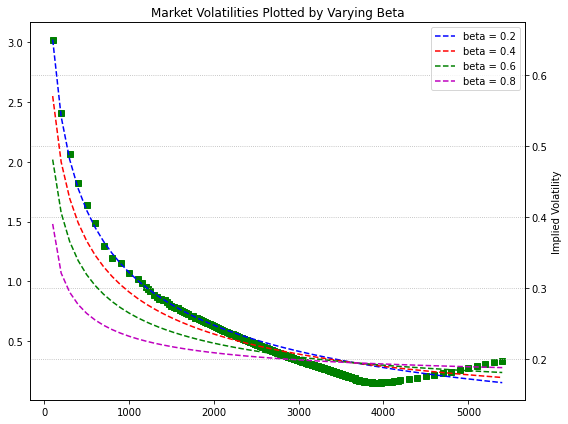

In [ ]:
# I will fix (calibrated) sigma = 0.195 and vary beta between 0 and 1 to make observations

sigma_dd = 0.195
beta_dd = np.arange(0.2, 1.2, 0.2)
# tempResult = SPXresult[SPXresult['maturityDays'] == 45.0]

plotDDM(tempResult2, sigma_dd, beta_dd)

##### As beta increase for the DDM increases, implied volatility smile for DDM becomes steeper.

Discuss how does change ρ, ν in the SABR model affect the shape of the implied volatility smile.

In [ ]:
def plotSABR(df, alpha, nu_sabr, rho_sabr, vary_nu = False, beta = 0.7):
    F = df['F'].values[0]
    T = df['T'].values[0]
    r = df['r'].values[0]
    S = df['S'].values[0]

    if vary_nu is False:
        for i, rho in enumerate(rho_sabr):

            sabrvols = []

            for K in df['strike_price']:
                sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu_sabr))
            
            globals()[f"rho_{i+1}"] = sabrvols
            
        fig = plt.figure(tight_layout=True, figsize = (8,6))
        ax = fig.add_subplot(111)
        ax.plot(df['strike_price'], df['impliedVol'], 'gs', label='Market Vols')

        ax2 = ax.twinx()
        ax2.plot(df['strike_price'], rho_1, 'b--', label='rho = {}'.format(rho_sabr[0]))
        ax2.plot(df['strike_price'], rho_2, 'r--', label='rho = {}'.format(rho_sabr[1]))
        ax2.plot(df['strike_price'], rho_3, 'g--', label='rho = {}'.format(rho_sabr[2]))
        ax2.plot(df['strike_price'], rho_4, 'm--', label='rho = {}'.format(rho_sabr[3]))
        ax2.plot(df['strike_price'], rho_5, 'y--', label='rho = {}'.format(rho_sabr[4]))

        plt.grid(linestyle='dotted')
        plt.legend()
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.title("Market Volatilities Plotted by Varying Rho")
        plt.show()
    
    else:
        for i, nu in enumerate(nu_sabr):

            sabrvols = []

            for K in df['strike_price']:
                sabrvols.append(SABR(F, K, T, alpha, beta, rho_sabr, nu))
            
            globals()[f"nu_{i+1}"] = sabrvols

        fig = plt.figure(tight_layout=True, figsize = (8,6))
        ax = fig.add_subplot(111)
        ax.plot(df['strike_price'], df['impliedVol'], 'gs', label='Market Vols')

        ax2 = ax.twinx()
        ax2.plot(df['strike_price'], nu_1, 'b--', label='nu = {}'.format(round(nu_sabr[0],2)))
        ax2.plot(df['strike_price'], nu_2, 'r--', label='nu = {}'.format(round(nu_sabr[1],2)))
        ax2.plot(df['strike_price'], nu_3, 'g--', label='nu = {}'.format(round(nu_sabr[2],2)))
        ax2.plot(df['strike_price'], nu_4, 'm--', label='nu = {}'.format(round(nu_sabr[3],2)))
        ax2.plot(df['strike_price'], nu_5, 'y--', label='nu = {}'.format(round(nu_sabr[4],2)))

        plt.grid(linestyle='dotted')
        plt.legend()
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.title("Market Volatilities Plotted by Varying Nu")
        plt.show()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


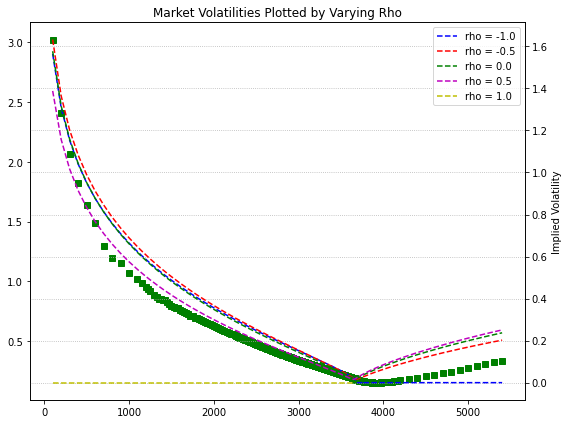

In [ ]:
# Observing the effect of varying rho (45days-SPX calibrated parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790)
# I will fix (calibrated) alpha = 1.817 and nu = 2.790 while varying rho between -1 and 1 to make observations

alpha_sabr = 0.195
nu_sabr = 2.790
rho_sabr = np.arange(-1, 1.5, 0.5)
# tempResult = SPXresult[SPXresult['maturityDays'] == 45.0]

plotSABR(tempResult2, alpha_sabr, nu_sabr, rho_sabr, False)

##### From the graph, as rho increases in the SABR model , the slope of the implied volatility smile will decrease. Positive correlation between stock and volatility is associated with positive skew in return distribution. Negative correlation between stock and volatility is associated with negative skew in return distribution. Negative correlation increases the price of out-of-the-money put options and decreases the price of out-of-the-money call options.

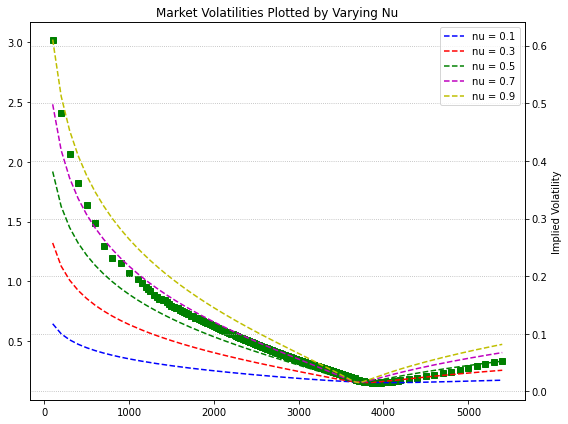

In [ ]:
# Observing the effect of varying nu (45days-SPX calibrated parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790)
# I will fix (calibrated) alpha = 1.817 and rho = -0.404 while varying nu between 0.1 and 0.9 to make observations

alpha_sabr = 0.195
nu_sabr = np.arange(0.1, 1.1, 0.2)
rho_sabr = -0.404
# tempResult = SPXresult[SPXresult['maturityDays'] == 45.0]

plotSABR(tempResult2, alpha_sabr, nu_sabr, rho_sabr, True)

##### From the graph, we can infer that as nu increases, the curvature of the implied volatility smile will become more pronounced. Increasing volatility-of-volatility has the effect of increasing the kurtosis of return. When the volatility-of-volatility parameter is 0, volatility will be deterministic. Larger volatility-ofvolatility ν increases the price of out-of-the-money call and put options.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=84dba4f4-47dd-4672-95f1-e2f4f6eed8bc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>